# Tesla Stock Prediction

[Tesla, Inc.](https://en.wikipedia.org/wiki/Tesla,_Inc.) is  is an American multinational automotive and clean energy company headquartered in Austin, Texas, which designs and manufactures electric vehicles (cars and trucks), stationary battery energy storage devices from home to grid-scale, solar panels and solar shingles, and related products and services. In this project, we are going through a dataset containing information about the Tesla stock prices. The data was made avaliable by [kaggle](https://www.kaggle.com/datasets/timoboz/tesla-stock-data-from-2010-to-2020) and our main goal is to predict the stock closing price. This report is divided in 5 parts:

* Setting up the data
* Exploratory data analysis
* Model training
* Model Evaluation
* Conclusion

## Setting up the data

We start our project by loading the required packages and data. The dataset was previously loaded to a BigQuery table.

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import db_dtypes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, KFold
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from joblib import dump, load

credentials = service_account.Credentials.from_service_account_file(
'credentials.json')

project_id = 'platinum-factor-405117'
client = bigquery.Client(credentials=credentials,project=project_id)

query = """
   SELECT *
   FROM datascience.tesla_stock
   """
df = pd.read_gbq(query, project_id=project_id, credentials=credentials)
df.tail()

,Date,Open,High,Low,Close,Adj_Close,Volume
2411,2011-04-27,26.93,27.360001,26.629999,27.080000,27.080000,996900
2412,2012-01-30,29.49,29.610001,28.530001,29.570000,29.570000,729000
2413,2011-03-22,22.73,22.860001,22.000000,22.190001,22.190001,582900
2414,2011-10-25,28.23,28.860001,27.799999,28.250000,28.250000,654400
2415,2020-01-21,530.25,548.580017,528.409973,547.200012,547.200012,17803500


We have 2416 rows and 7 columns. According to the data description, each variable is related to the stock in a given moment.

1. Date: Date of the event
2. Open: Opening stock price on the date
3. High: Highest stock price on the date
4. Low: Lowest price on the date
5. Cloce: Closing stock price on the date
6. Adj_Cloce: Adjusted clocing stock price on the date
7. Volume: Trading volume on the date

Let us get some general information from the data and check if there any null values.

In [2]:
df.describe()

,Open,High,Low,Close,Adj_Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2416.0
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5572721.688742
std,118.740163,120.892329,116.857591,119.136020,119.136020,4987809.151888
min,16.139999,16.629999,14.980000,15.800000,15.800000,118500.0
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1899275.0
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4578400.0
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7361150.0
max,673.690002,786.140015,673.520020,780.000000,780.000000,47065000.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   dbdate 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj_Close  2416 non-null   float64
 6   Volume     2416 non-null   Int64  
dtypes: Int64(1), dbdate(1), float64(5)
memory usage: 134.6 KB


There are no null values. The Date columns is with a dbdate type and the Volume is a Int64 columns. The others are float64 columns. The Close and Adj_Close columns have the same descriptive statistics. Therefore, it is very likely that they are redundant. Let us check that and if it is the case, drop the Adj_Close column. 

In [4]:
sum(df['Close']!=df['Adj_Close'])

0

In [5]:
df = df.drop('Adj_Close', axis=1)
df.tail()

,Date,Open,High,Low,Close,Volume
2411,2011-04-27,26.93,27.360001,26.629999,27.080000,996900
2412,2012-01-30,29.49,29.610001,28.530001,29.570000,729000
2413,2011-03-22,22.73,22.860001,22.000000,22.190001,582900
2414,2011-10-25,28.23,28.860001,27.799999,28.250000,654400
2415,2020-01-21,530.25,548.580017,528.409973,547.200012,17803500


Since we want to predict the closing value based on the date and opening prices, we are only keeping the Date, Open and Close columns. We are also changing the Date column type and extracting some new date columns to help in the data exploratory analysis and in the model training.

In [6]:
df = df[['Date', 'Open', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.dayofweek
df.tail()

,Date,Open,Close,Year,Month,Day,Weekday
2411,2011-04-27,26.93,27.080000,2011,4,27,2
2412,2012-01-30,29.49,29.570000,2012,1,30,0
2413,2011-03-22,22.73,22.190001,2011,3,22,1
2414,2011-10-25,28.23,28.250000,2011,10,25,1
2415,2020-01-21,530.25,547.200012,2020,1,21,1


Now let us split our dataset into two subsets. One will be used for training and the other one for testing. We will stratify our data by the year, in order to correctly catch any trends caused by inflation, economic growth, etc. We will use 20% of the observations for test.

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['Year'], random_state=1234)

df_train['Data'] = 'train'
df_train.tail()

,Date,Open,Close,Year,Month,Day,Weekday,Data
2024,2018-11-14,342.700012,344.000000,2018,11,14,2,train
614,2015-02-06,222.000000,217.360001,2015,2,6,4,train
2368,2011-01-24,23.530001,24.490000,2011,1,24,0,train
178,2017-05-10,321.559998,325.220001,2017,5,10,2,train
446,2019-06-18,228.720001,224.740005,2019,6,18,1,train


In [8]:
df_test['Data'] = 'test'
df_test.tail()

,Date,Open,Close,Year,Month,Day,Weekday,Data
1792,2017-03-22,251.559998,255.009995,2017,3,22,2,test
2145,2018-02-28,352.570007,343.059998,2018,2,28,2,test
1159,2018-10-02,313.950012,301.019989,2018,10,2,1,test
147,2011-11-11,31.900000,33.639999,2011,11,11,4,test
316,2014-02-18,205.240005,203.699997,2014,2,18,1,test


Now let us save our tidy data in a BigQuery table and finish this part of the project.

In [9]:
df = pd.concat([df_train, df_test], ignore_index=True)
df.tail()

,Date,Open,Close,Year,Month,Day,Weekday,Data
2411,2017-03-22,251.559998,255.009995,2017,3,22,2,test
2412,2018-02-28,352.570007,343.059998,2018,2,28,2,test
2413,2018-10-02,313.950012,301.019989,2018,10,2,1,test
2414,2011-11-11,31.900000,33.639999,2011,11,11,4,test
2415,2014-02-18,205.240005,203.699997,2014,2,18,1,test


In [10]:
df.to_gbq('datascience.tesla_stock_tidy', project_id=project_id, credentials=credentials, if_exists='replace')

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


## Exploratory data analysis

Let us start this part by loading the training data and plotting the closing stock price by the date. We are  also changing the Year, Month, Day, and Weekday columns to a categorical format. 

In [11]:
query = """select * from datascience.tesla_stock_tidy
            where Data='train'"""

df = pd.read_gbq(query, project_id=project_id, credentials=credentials)
df = df.drop('Data', axis=1)
df['Year'] = df['Year'].astype('category')
df['Month'] = df['Month'].astype('category')
df['Day'] = df['Day'].astype('category')
df['Weekday'] = df['Weekday'].astype('category')
df.tail()

,Date,Open,Close,Year,Month,Day,Weekday
1927,2014-10-31 00:00:00+00:00,242.509995,241.699997,2014,10,31,4
1928,2020-01-31 00:00:00+00:00,640.000000,650.570007,2020,1,31,4
1929,2010-12-31 00:00:00+00:00,26.570000,26.629999,2010,12,31,4
1930,2015-07-31 00:00:00+00:00,267.600006,266.149994,2015,7,31,4
1931,2017-03-31 00:00:00+00:00,278.730011,278.299988,2017,3,31,4


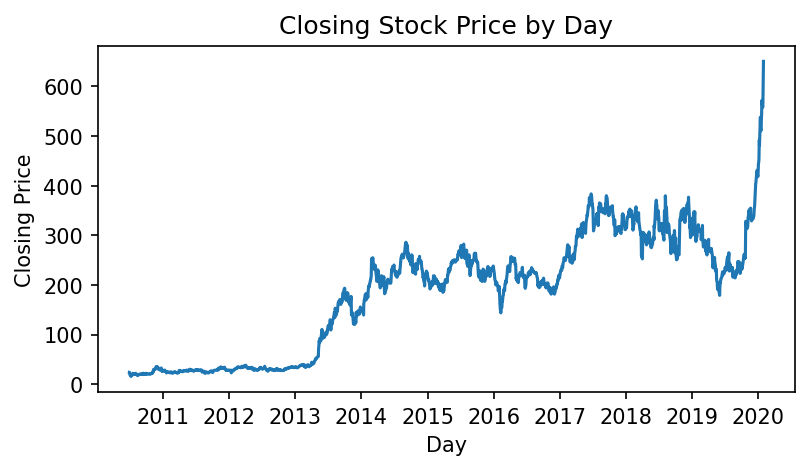

In [12]:
fig, ax = plt.subplots(figsize=(6,3), dpi=150)
sns.lineplot(data=df, x='Date', y='Close', ax=ax)
ax.set_title("Closing Stock Price by Day")
ax.set_xlabel('Day')
ax.set_ylabel("Closing Price")
plt.show()

The prices increased greatly from 2019 to 2020. Now let us see how the closing price varies with the opening price. 

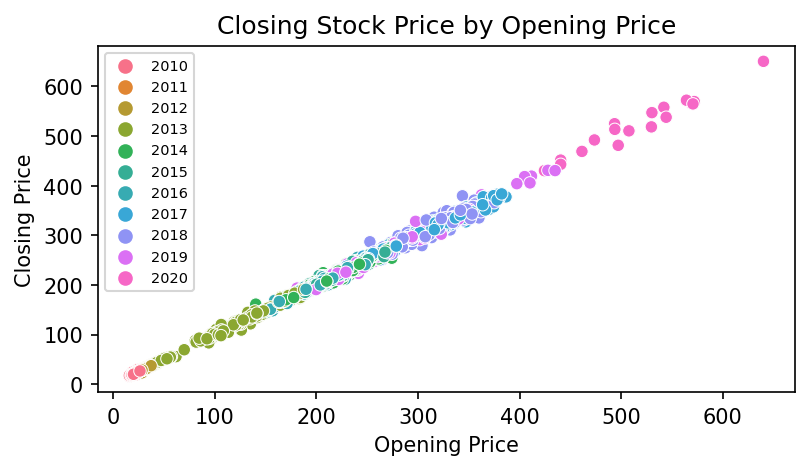

In [13]:
fig, ax = plt.subplots(figsize=(6,3), dpi=150)
sns.scatterplot(data=df, x='Open', y='Close', hue='Year', ax=ax)
ax.set_title('Closing Stock Price by Opening Price')
ax.set_xlabel('Opening Price')
ax.set_ylabel("Closing Price")
ax.legend(loc='upper left', fontsize='x-small')
plt.show()

As expected, the opening and closing prices are very related. The year is also very related to the opening price. Therefore, we will discard the Year variable and keep the Open, since it is the more meaningful one.

In [14]:
df = df.drop('Year', axis=1)
df.tail()

,Date,Open,Close,Month,Day,Weekday
1927,2014-10-31 00:00:00+00:00,242.509995,241.699997,10,31,4
1928,2020-01-31 00:00:00+00:00,640.000000,650.570007,1,31,4
1929,2010-12-31 00:00:00+00:00,26.570000,26.629999,12,31,4
1930,2015-07-31 00:00:00+00:00,267.600006,266.149994,7,31,4
1931,2017-03-31 00:00:00+00:00,278.730011,278.299988,3,31,4


As we have seen, the Open variable is already a great estimator to the closing price. We intend to use the other variables to catch the small fluctuations that may occur. We are going to use some boxplots to see if the Month, Day and Weekday have any significance in determining  the closing price. Let us start with the weekday.

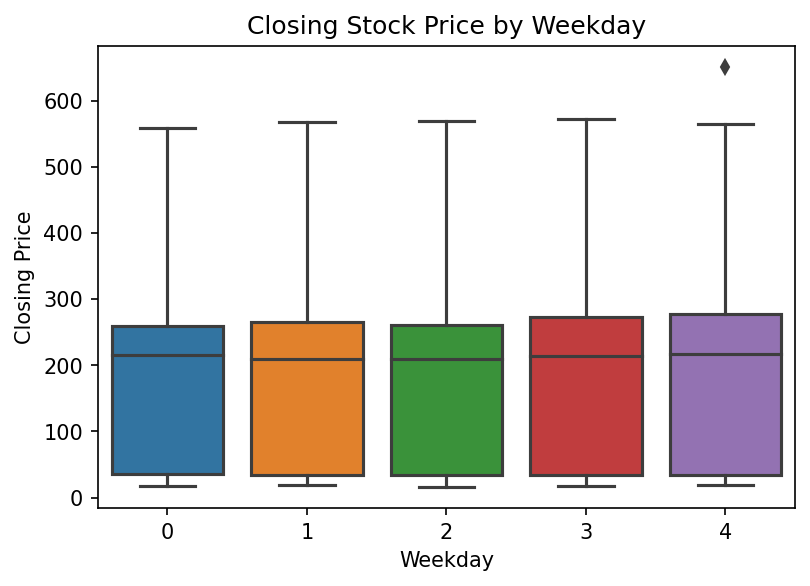

In [15]:
fig, ax = plt.subplots(figsize=(6,4), dpi=150)
sns.boxplot(data=df, x='Weekday', y='Close', ax=ax)
ax.set_title("Closing Stock Price by Weekday")
ax.set_ylabel('Closing Price')
plt.show()


There are no meaningful differences in the closing price between the weekdays. Now let us see how the months behave.

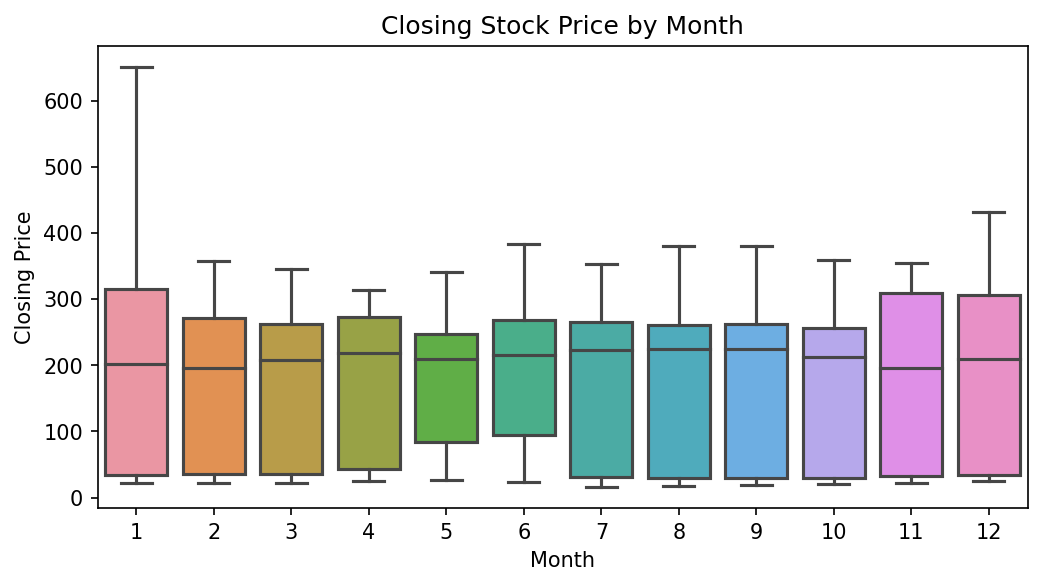

In [16]:
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
sns.boxplot(data=df, x='Month', y='Close', ax=ax)
ax.set_title("Closing Stock Price by Month")
ax.set_ylabel('Closing Price')
plt.show()


Now we have some notable differences. For instance, the closing price mean for july and august are greater than the mean for november and february. Now let us check the days.

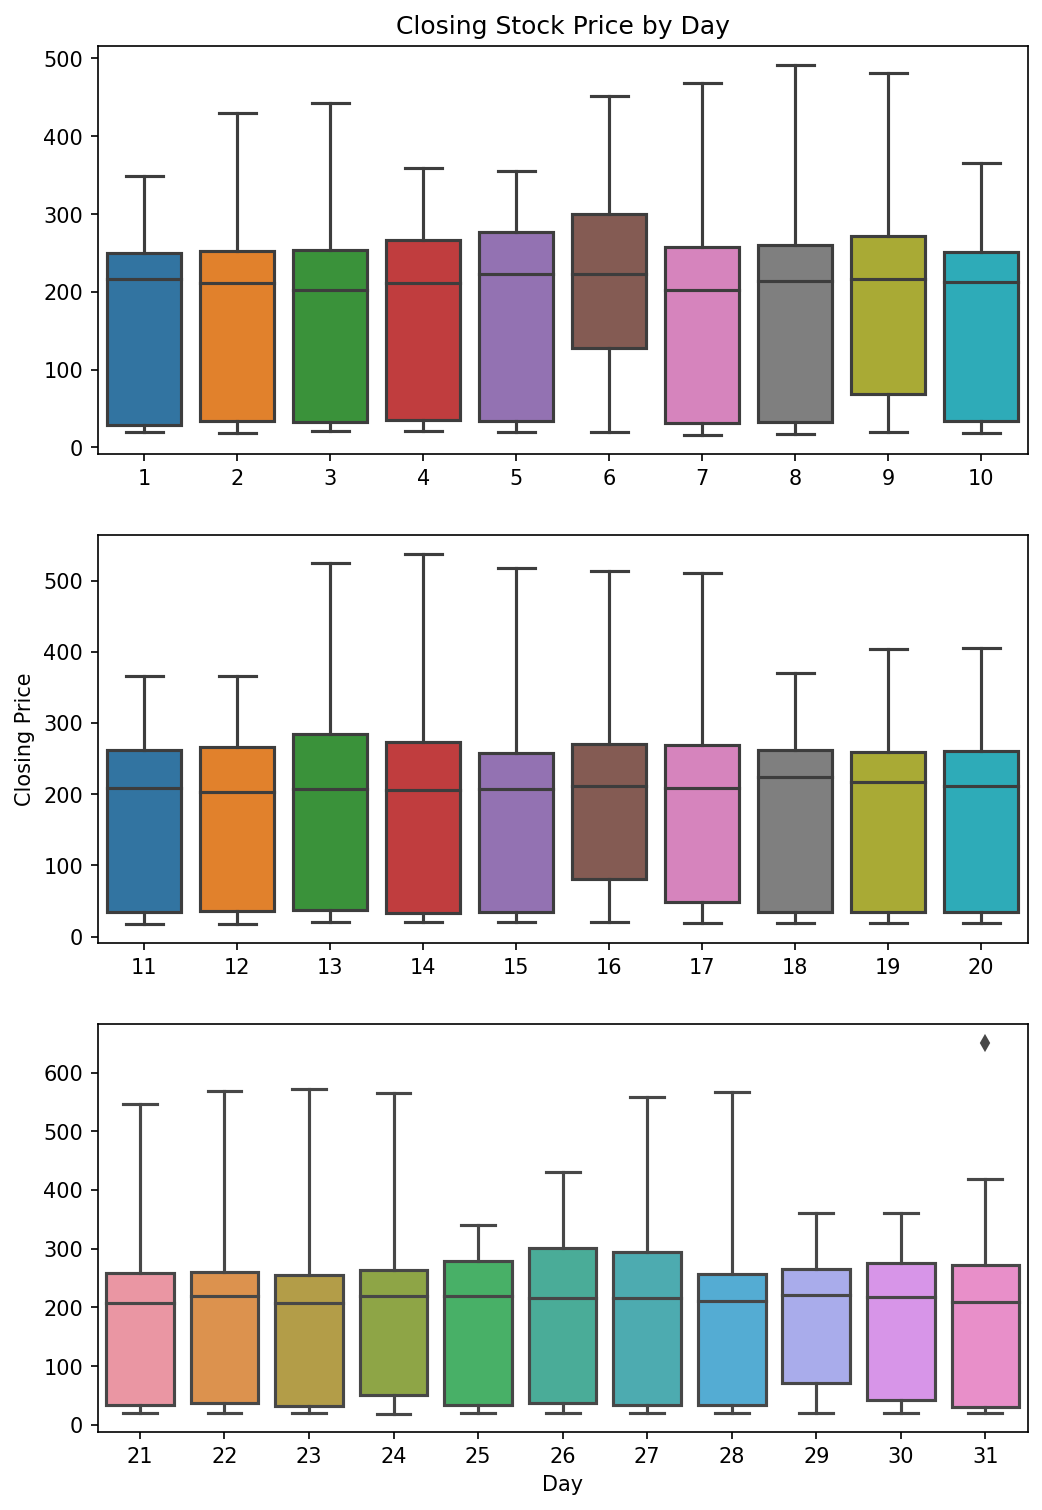

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(8,12), dpi=150)
df['Day'] = df['Day'].astype('int')
sns.boxplot(data=df.query('Day<11'), x='Day', y='Close', ax=ax[0])
sns.boxplot(data=df.query('Day>=11&Day<21'), x='Day', y='Close', ax=ax[1])
sns.boxplot(data=df.query('Day>=21'), x='Day', y='Close', ax=ax[2])
ax[0].set_title("Closing Stock Price by Day")
ax[0].set_ylabel('')
ax[1].set_ylabel('Closing Price')
ax[2].set_ylabel('')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('Day')
plt.show()
df['Day'] = df['Day'].astype('category')

The mean for the first days seems to be slightly greater than the mean for the rest of the days. Therefore, we will be using the Open, Month and Day variables as our estimators.

## Model Training

We will be using 3 different types of regressions models:

* OLS
* Lasso
* Ridge

We will compare the models using the following metrics:

* MAE
* RMSE
* R²
* SI

First, we have to split our data into a training and a validation subset.

In [18]:
df['Month'] = df['Month'].astype('int')
df['Day'] = df['Day'].astype('int')
df_train, df_validation = train_test_split(df, test_size=0.2, shuffle=True, random_state=1234)
df_train = df_train.reset_index(drop=True)
df_train.tail()

,Date,Open,Close,Month,Day,Weekday
1540,2016-07-07 00:00:00+00:00,213.100006,215.940002,7,7,3
1541,2016-10-26 00:00:00+00:00,201.000000,202.240005,10,26,2
1542,2013-11-14 00:00:00+00:00,138.919998,137.600006,11,14,3
1543,2017-08-29 00:00:00+00:00,339.480011,347.359985,8,29,1
1544,2013-11-06 00:00:00+00:00,154.809998,151.160004,11,6,2


In [19]:
df_validation = df_validation.reset_index(drop=True)
df_validation.tail()

,Date,Open,Close,Month,Day,Weekday
382,2013-05-13 00:00:00+00:00,80.989998,87.800003,5,13,0
383,2015-09-11 00:00:00+00:00,247.639999,250.240005,9,11,4
384,2010-12-02 00:00:00+00:00,34.009998,32.349998,12,2,3
385,2012-11-21 00:00:00+00:00,32.610001,32.470001,11,21,2
386,2011-10-25 00:00:00+00:00,28.230000,28.250000,10,25,1


Now lets separate our estimators from our target and start the training.

In [20]:
X_train = df_train[['Open', 'Month', 'Day']].copy()
y_train = df_train['Close'].copy()
X_validation = df_validation[['Open', 'Month', 'Day']].copy()
y_validation = df_validation['Close'].copy()

Now we have to establish a baseline model, which our models will have to outperform. In this case, we want our models to be better than guessing the opening price as the closing price.

### Baseline

In [21]:
base_mae = mean_absolute_error(y_validation, X_validation['Open'])
base_rmse = mean_squared_error(y_validation, X_validation['Open'], squared=False)
base_si = base_rmse/y_validation.mean()
base_r2 = r2_score(y_validation, X_validation['Open'])

print("MAE: ", base_mae)
print("RMSE: ", base_rmse)
print("SI: ", base_si)
print("R²: ", base_r2)

MAE:  3.050439214470285
RMSE:  4.926959145911481
SI:  0.026321130011178563
R²:  0.9982569140052968


The baseline model is already very good and it will be too hard to beat it. 

### OLS

In [22]:
reg = linear_model.LinearRegression()
reg = reg.fit(X_train, y_train)
pred = reg.predict(X_validation)
ols_mae = mean_absolute_error(y_validation, pred)
ols_rmse = mean_squared_error(y_validation, pred, squared=False)
ols_si = ols_rmse/y_validation.mean()
ols_r2 = r2_score(y_validation, pred)
print("MAE: ", ols_mae)
print("RMSE: ", ols_rmse)
print("SI: ", ols_si)
print("R²: ", ols_r2)

MAE:  3.0558844852313105
RMSE:  4.924166925817812
SI:  0.026306213226620634
R²:  0.9982588891386205


Our R² is very close to 1, which is expected, since the closing price was already very close to the opening price. Our SI is below 10%, which is very good, but again, it is expected. Comparing to our baseline model, the OLS model has a slightly worse MAE and a slightly better RMSE, SI e R², but the numbers are basically the same.

### Ridge

For the ridge regression, we first have to find the best $\lambda$ value. In order to do that, we will be using a k-fold with k=5 with 10 different $\lambda$ values. Since we don't want to lose too much influence of the estimators, we will only be testing small $\lambda$. The interval will be set from 0.1 to 2. 

In [23]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
kf.get_n_splits(X_train, y_train)
kf

KFold(n_splits=5, random_state=42, shuffle=True)

In [24]:
rmse = np.inf
l_final=0
for l in np.arange(0.2, 2.2, 0.2):
    reg = linear_model.Ridge(alpha=l, random_state=42)
    rmse_aux=0
    for train_index, test_index in kf.split(X_train, y_train):
        reg = reg.fit(X_train.loc[train_index], y_train.loc[train_index])
        pred = reg.predict(X_train.loc[test_index])
        rmse_aux += mean_squared_error(y_train.loc[test_index], pred, squared=False)
    rmse_aux = rmse_aux/5
    if rmse_aux < rmse:
        rmse = rmse_aux
        l_final = l
print("Best lambda: ", l_final)


Best lambda:  2.0


We have found $\lambda=2$. Now let us train our model with this parameter and evaluate it in the validation data.

In [25]:
reg = linear_model.Ridge(alpha=2, random_state=42)
reg = reg.fit(X_train, y_train)
pred = reg.predict(X_validation)
ridge_mae = mean_absolute_error(y_validation, pred)
ridge_rmse = mean_squared_error(y_validation, pred, squared=False)
ridge_si = ols_rmse/y_validation.mean()
ridge_r2 = r2_score(y_validation, pred)
print("MAE: ", ridge_mae)
print("RMSE: ", ridge_rmse)
print("SI: ", ridge_si)
print("R²: ", ridge_r2)

MAE:  3.0558823289440036
RMSE:  4.924166933835288
SI:  0.026306213226620634
R²:  0.9982588891329508


The results were basically the same.

### Lasso

For the Lasso model we also have to estimate a $\lambda$. We will be using the same approach adopted for the Ridge model

In [26]:
rmse = np.inf
l_final=0
for l in np.arange(0.2, 2.2, 0.2):
    reg = linear_model.Lasso(alpha=l, random_state=42)
    rmse_aux=0
    for train_index, test_index in kf.split(X_train, y_train):
        reg = reg.fit(X_train.loc[train_index], y_train.loc[train_index])
        pred = reg.predict(X_train.loc[test_index])
        rmse_aux += mean_squared_error(y_train.loc[test_index], pred, squared=False)
    rmse_aux = rmse_aux/5
    if rmse_aux < rmse:
        rmse = rmse_aux
        l_final = l
print("Best lambda: ", l_final)


Best lambda:  1.4000000000000001


We have found $\lambda=1.4$. Now let us train our model with this parameter and evaluate it in the validation data.

In [27]:
reg = linear_model.Lasso(alpha=1.4, random_state=42)
reg = reg.fit(X_train, y_train)
pred = reg.predict(X_validation)
lasso_mae = mean_absolute_error(y_validation, pred)
lasso_rmse = mean_squared_error(y_validation, pred, squared=False)
lasso_si = ols_rmse/y_validation.mean()
lasso_r2 = r2_score(y_validation, pred)
print("MAE: ", lasso_mae)
print("RMSE: ", lasso_rmse)
print("SI: ", lasso_si)
print("R²: ", lasso_r2)

MAE:  3.0441752403129945
RMSE:  4.927222525681794
SI:  0.026306213226620634
R²:  0.9982567276405041


So far, the Lasso model was the better one. We have a slightly better MAE, but the results are basically the same. Therefore, we will use all three models. Let us train them with the whole data and save them.

### Final Model

In [28]:
X = df[['Open', 'Month', 'Day']].copy()
y = df['Close'].copy()

reg_ols = linear_model.LinearRegression().fit(X, y)
dump(reg_ols, "models/ols.joblib")

reg_ridge = linear_model.Ridge(alpha=2).fit(X, y)
dump(reg_ridge, "models/ridge.joblib")

reg_lasso = linear_model.Lasso(alpha=1.4).fit(X, y)
dump(reg_lasso, "models/lasso.joblib")


['models/lasso.joblib']

## Model Evaluation

To test our model, we first need to load the test dataset and our final model.

In [29]:
reg_ols = load("models/ols.joblib")
reg_ridge = load("models/ridge.joblib")
reg_lasso = load("models/lasso.joblib")

In [30]:
df_test = pd.read_gbq("""select * from datascience.tesla_stock_tidy
                            where Data='test'""")
df_test.tail()

,Date,Open,Close,Year,Month,Day,Weekday,Data
479,2015-01-30 00:00:00+00:00,203.960007,203.600006,2015,1,30,4,test
480,2012-11-30 00:00:00+00:00,33.630001,33.820000,2012,11,30,4,test
481,2018-08-31 00:00:00+00:00,302.000000,301.660004,2018,8,31,4,test
482,2014-01-31 00:00:00+00:00,178.850006,181.410004,2014,1,31,4,test
483,2019-05-31 00:00:00+00:00,185.100006,185.160004,2019,5,31,4,test


Now let us see the performance of the baseline versus the selected models.

### Baseline

In [31]:
X = df_test[['Open', 'Month', 'Day']]
y = df_test['Close']

base_mae = mean_absolute_error(y, X['Open'])
base_rmse = mean_squared_error(y, X['Open'], squared=False)
base_si = base_rmse/y.mean()
base_r2 = r2_score(y, X['Open'])

print("MAE: ", base_mae)
print("RMSE: ", base_rmse)
print("SI: ", base_si)
print("R²: ", base_r2)

MAE:  3.466384661157024
RMSE:  6.945857103556663
SI:  0.03686813239756074
R²:  0.996725865610978


### OLS

In [34]:
pred = reg_ols.predict(X)

ols_mae = mean_absolute_error(y, pred)
ols_rmse = mean_squared_error(y, pred, squared=False)
ols_si = ols_rmse/y.mean()
ols_r2 = r2_score(y, pred)

print("MAE: ", ols_mae)
print("RMSE: ", ols_rmse)
print("SI: ", ols_si)
print("R²: ", ols_r2)

MAE:  3.481329240762456
RMSE:  6.924128303648323
SI:  0.036752797420189755
R²:  0.9967463185892722


### Ridge

In [35]:
pred = reg_ridge.predict(X)

ridge_mae = mean_absolute_error(y, pred)
ridge_rmse = mean_squared_error(y, pred, squared=False)
ridge_si = ridge_rmse/y.mean()
ridge_r2 = r2_score(y, pred)

print("MAE: ", ridge_mae)
print("RMSE: ", ridge_rmse)
print("SI: ", ridge_si)
print("R²: ", ridge_r2)

MAE:  3.481326896630573
RMSE:  6.924129655964464
SI:  0.03675280459819094
R²:  0.9967463173183523


### Lasso

In [36]:
pred = reg_lasso.predict(X)

lasso_mae = mean_absolute_error(y, pred)
lasso_rmse = mean_squared_error(y, pred, squared=False)
lasso_si = lasso_rmse/y.mean()
lasso_r2 = r2_score(y, pred)

print("MAE: ", lasso_mae)
print("RMSE: ", lasso_rmse)
print("SI: ", lasso_si)
print("R²: ", lasso_r2)

MAE:  3.467456470332174
RMSE:  6.931771734282126
SI:  0.03679336822496982
R²:  0.9967391312543546


## Conclusion

The Lasso model had the lowest MAE, whereas the OLS model had the lowest RMSE and SI. None of the models could outperform the baseline R². However, since the differences were very low, the results were basically the same. Therefore, we conclude that the temporal data is not significant to predict fluctuations in the stock prices.